# Convert Faust to JAX in DawDreamer

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/DBraun/DawDreamer/blob/main/examples/Faust_to_JAX/Faust_to_JAX.ipynb)

[Faust](https://faust.grame.fr/) (**F**unctional **AU**dio **ST**ream) is a functional programming language for sound synthesis and audio processing with a strong focus on the design of synthesizers, musical instruments, and audio effects. Faust targets high-performance signal processing applications and audio plug-ins for a variety of platforms and standards.

The core component of Faust is its compiler. It enables the translation of any Faust digital signal processing (DSP) code to a wide range of non-domain specific languages such as C++, C, LLVM bit code, WebAssembly, Rust, Julia and more. In this Python notebook, we'll use [DawDreamer](https://github.com/DBraun/DawDreamer/) to translate Faust into [JAX](https://jax.readthedocs.io/)/[Flax](https://flax.readthedocs.io/) code. Specifically, we'll write Faust code with user-interface parameters which will become learnable parameters. These parameters will be optimized using gradient descent. After reading the notebook, you'll be ready to explore other JAX/Flax training procedures.

## Installation

**Before installing the requirements, change your Runtime Hardware Accelerator to None.** When Faust is converted to JAX, the resulting code produces audio one sample at a time. CPUs are good for this rather than GPUs/TPUs, so we select None.

Now we can install the requirements:

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install numpy scipy librosa jax flax optax
else:
    print('skipped installation')

skipped installation


In [2]:
try:
    import dawdreamer
except ModuleNotFoundError:
    !pip install dawdreamer

And importing the libraries:

In [3]:
from functools import partial
import itertools

from tqdm.notebook import tqdm

import jax
default_device = 'cpu'
jax.config.update('jax_platform_name', default_device)
import jax.numpy as jnp
from jax import random

from flax import linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
from flax.core.frozen_dict import unfreeze
import optax

from dawdreamer.faust import createLibContext, destroyLibContext, FaustContext
from dawdreamer.faust.box import *

import numpy as np
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio
import IPython.display as ipd

Define some constants and utilities:

In [4]:
SAMPLE_RATE = 44100

def show_audio(data, autoplay=False):
    if abs(data).max() > 1.:
        data /= abs(data).max()
    
    ipd.display(Audio(data=data, rate=SAMPLE_RATE, normalize=False, autoplay=autoplay))

## Faust Basics

If you're fluent in Faust, you can skip this block:

Let's write some Faust code for a low-pass filter with a cutoff frequency as a user interface slider:

```faust
import("stdfaust.lib");
cutoff = hslider("cutoff", 440., 20., 20000., .01);
process = fi.lowpass(1, cutoff);
```

We define a cutoff parameter initialized at 440, with a range of 20 to 20000., with a step size of .01 (The step size doesn't matter for JAX).

The code above uses `fi.lowpass` from the [Faust Libraries](https://faustlibraries.grame.fr/libs/filters/#filowpass). Specifically, `fi.lowpass` takes three arguments: 
* `N`: the filter order (number of poles) (non-negative, constant numerical expression)
* `fc`: the filter cutoff in Hz
* `s`: the signal which will be filtered

If we specify only two arguments by writing `fi.lowpass(1, 440.)`, the result is a [partial application](https://en.wikipedia.org/wiki/Partial_application) which takes the right-most arguments that weren't specified, in this case an input signal.

Thus, `fi.lowpass(1, 440.)` is equivalent to `_ : fi.lowpass(1, 440.) : _`. This is a single identity operator `_` sequenced into a filter, outputting a single identity operator `_`.

We can replace `440.` with a UI slider:
```faust
import("stdfaust.lib");
cutoff = hslider("cutoff", 440., 20., 20000., .01);
process = fi.lowpass(1, cutoff);
```

Note that the code above is equivalent to the code below in which we move `cutoff` outside of the lowpass function:
```faust
import("stdfaust.lib");
cutoff = hslider("cutoff", 440., 20., 20000., .01);
process = cutoff, _ : fi.lowpass(1);
```
or even
```faust
import("stdfaust.lib");
cutoff = hslider("cutoff", 440., 20., 20000., .01);
myFilter(x) = cutoff, x : fi.lowpass(1);
process = myFilter;
```

## Exporting Code

Let's proceed with the following Faust code:

In [5]:
faust_code = """
import("stdfaust.lib");
cutoff = hslider("cutoff", 440., 20., 20000., .01);
process = fi.lowpass(1, cutoff);
"""

To convert it to Faust with DawDreamer, we must first convert it to a Box:

In [6]:
with FaustContext():
    box = boxFromDSP(faust_code)

    assert box.inputs == 1
    assert box.outputs == 1
    
    # Now we can convert it to C++ and specify a C++ class name MyDSP:
    
    module_name = "MyDSP"
    cpp_code = boxToSource(box, 'cpp', module_name)
    print(cpp_code)

/* ------------------------------------------------------------
name: "dawdreamer"
Code generated with Faust 2.69.3 (https://faust.grame.fr)
Compilation options: -lang cpp -ct 1 -cn MyDSP -es 1 -mcd 16 -single -ftz 0
------------------------------------------------------------ */

#ifndef  __MyDSP_H__
#define  __MyDSP_H__

#ifndef FAUSTFLOAT
#define FAUSTFLOAT float
#endif 

#include <algorithm>
#include <cmath>
#include <cstdint>
#include <math.h>

#ifndef FAUSTCLASS 
#define FAUSTCLASS MyDSP
#endif

#ifdef __APPLE__ 
#define exp10f __exp10f
#define exp10 __exp10
#endif

#if defined(_WIN32)
#define RESTRICT __restrict
#else
#define RESTRICT __restrict__
#endif


class MyDSP : public dsp {
	
 private:
	
	float fVec0[2];
	FAUSTFLOAT fHslider0;
	int fSampleRate;
	float fConst0;
	float fRec0[2];
	
 public:
	MyDSP() {}

	void metadata(Meta* m) { 
		m->declare("compile_options", "-lang cpp -ct 1 -cn MyDSP -es 1 -mcd 16 -single -ftz 0");
		m->declare("name", "dawdreamer");
	}

	virtual int g

Next, let's convert the box to JAX.

In [7]:
with FaustContext():
    box = boxFromDSP(faust_code)

    assert box.inputs == 1
    assert box.outputs == 1
        
    module_name = "MyDSP"
    jax_code = boxToSource(box, 'jax', module_name, ['-a', 'jax/minimal.py'])
    print(jax_code)

# ************************************************************************
# FAUST Architecture File
# Copyright (C) 2022 GRAME, Centre National de Creation Musicale
# ---------------------------------------------------------------------

# This is sample code. This file is provided as an example of minimal
# FAUST architecture file. Redistribution and use in source and binary
# forms, with or without modification, in part or in full are permitted.
# In particular you can create a derived work of this FAUST architecture
# and distribute that work under terms of your choice.

# This sample code is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
# ************************************************************************

import json
import re
import dataclasses
from pathlib import Path
from typing import List

import numpy as np
import librosa
import jax
import jax.numpy

Note that if you have Faust installed on your computer, you don't need DawDreamer to convert to JAX or any of the other backends. Put your faust code in a file such as `faust_code.dsp`. Then in a Terminal/cmd window, run:

```bash
faust -i faust_code.dsp -lang jax -a minimal.py -o my_output.py
```

Because we're using the JAX backend (`-lang jax`), we can specify an architecture file [`-a minimal.py`](https://github.com/grame-cncm/faust/blob/master-dev/architecture/jax/minimal.py). This architecture file is where we define many of the methods of the Flax module which don't depend on the generated DSP code. For example, a method for reading audio files from the filesystem is independent of the generated DSP code which uses the audio file. Read more about architecture files [here](https://faustdoc.grame.fr/manual/architectures/).

The next part is a little scary in terms of security. We'll execute the generated JAX code using python's [`exec`](https://docs.python.org/3/library/functions.html#exec) and then fetch the class.

In [8]:
def faust2jax(faust_code: str):
    module_name = "MyDSP"

    with FaustContext():
    
      box = boxFromDSP(faust_code)
      
      jax_code = boxToSource(box, 'jax', module_name, ['-a', 'jax/minimal.py'])
    
    custom_globals = {}

    exec(jax_code, custom_globals)  # security risk!

    MyDSP = custom_globals[module_name]
    # MyDSP is now a class definition which can be instantiated or subclassed.

    # Before we bother to vmap the class, which would allow batch-processing,
    # let's jit compile the class for single-item inference:
    jit_inference_fn = jax.jit(partial(MyDSP(SAMPLE_RATE).apply, mutable='intermediates'), static_argnums=[2])
    # We specify mutable='intermediates' to access intermediate variables, which are
    # human-interpretable.
    # Our architecture file normalized all of the parameters to be between -1 and 1.
    # During a forward pass, the parameters are remapped to their original ranges
    # and stored as intermediate variables.

    # Note that MyDSP's forward method is the following:
    # @nn.compact
    # def __call__(self, x, T: int) -> jnp.array:

    # This takes two arguments, `x` (an input signal shaped `(C, T)`), and `T` the number of samples of the output.
    # Earlier, we specified static_argnums=[2] because T is a constant.

    # In our vmap code, we specify `in_axes=(0, None)` to batch along `x` but not along `T`.
    MyDSP = nn.vmap(MyDSP, in_axes=(0, None), variable_axes={'params': None}, split_rngs={'params': False})

    # Now we can create a model that handles batches of input.
    model_batch = MyDSP(SAMPLE_RATE)
    
    return model_batch, jit_inference_fn

hidden_model, jit_inference_fn = faust2jax(faust_code)

Let's demonstrate how to use the single-item inferencer:

In [9]:
# T is the number of audio samples of input and output
T = int(SAMPLE_RATE*1.0)

batch_size = 8

input_shape = (batch_size, hidden_model.getNumInputs(), T)

key = random.PRNGKey(0)

noises = -1. + 2.*random.uniform(key, shape=input_shape)
noise = noises[0]

params = hidden_model.init({'params': random.PRNGKey(0)}, noises, T)['params']
print('normalized params: ', params)
audio, mod_vars = jit_inference_fn({'params': params}, noise, T)
print('un-normalized params: ', mod_vars['intermediates'])

print('input audio (LOUD!!):')
show_audio(np.array(noise))
audio = np.array(audio)
print('output audio (less loud):')
show_audio(audio)

normalized params:  {'_dawdreamer/cutoff': Array(-0.957958, dtype=float32)}
un-normalized params:  {'dawdreamer/cutoff': (Array(439.99976, dtype=float32),)}
input audio (LOUD!!):


output audio (less loud):


### Pathnames

First, look at the `un-normalized` parameters above where you'll see `dawdreamer/cutoff`. We defined our Faust `cutoff` parameter as `hslider("cutoff", 440., 20., 20000., .01)`. Faust uses [labels as pathnames](https://faustdoc.grame.fr/manual/syntax/#labels-as-pathnames), kind of like a filesystem. We didn't define a root level name of our Faust code (such as `declare name "foo";`), so the root defaults to `dawdreamer`. Therefore `dawdreamer/cutoff` is the full path. If your Faust code involves [groups](https://faustdoc.grame.fr/manual/syntax/#hgroup-primitive) and other [dynamic syntax](https://faustdoc.grame.fr/manual/syntax/#labels-as-pathnames:~:text=of%20attach.-,Variable%20Parts%20of%20a%20Label,-Labels%20can%20contain) such as `hgroup("effect", hslider("cutoff %i", 440., 20., 20000., .01))`, then the path could be `effect/cutoff 1` and so on.

### Normalization

Next, look at the `normalized params` containing `_dawdreamer/cutoff`. Normalized parameters are preceded with an underscore so JAX can distinguish them from the un-normalized parameters. All normalized parameters are constrained to -1. and 1. Our Faust `cutoff` parameter has the range [20., 20000], so 440 gets remapped fairly close to -1. During the JAX `__call__`, the parameter gets remapped to its original range [20., 20000]. During training, this trick helps us use similar learning rates regardless of the range of our parameters. Consider how the range of a cutoff frequency [20., 20000] is very different from the range of a possible gain slider [-80, 0] measured in decibels. You can further customize the normalization by applying a scale such as `hslider("cutoff[scale:exp], 440., 20., 20000., .01)`. Check the [architecture file](https://github.com/grame-cncm/faust/blob/master-dev/architecture/jax/minimal.py) for more details. 

### Intermediate variables

Fortunately, we can look at `un-normalized params` above to inspect the human-interpretable value of the parameter, which is approximately 440.0. For more information, read the Flax docs about [intermediate variables](https://flax.readthedocs.io/en/latest/guides/extracting_intermediates.html). If you'd like to normalize parameters differently, feel free to subclass the generated class or contribute to the [architecture file](https://github.com/grame-cncm/faust/blob/master-dev/architecture/jax/minimal.py).

## Training

We'll use our previously created batched model to create a dataset of `(x,y)` pairs of noise and noise low-pass filtered at 440 Hz. Then we'll create a new version of our batched model **with the filter cutoff initialized at 10,000 Hz**. We'll use gradient descent to optimize this second model until it achieves an L1 time-domain loss near zero, and the hidden cutoff parameter of 440 Hz is found.

In [10]:
# Repeat the code much earlier, except create a model whose cutoff is 10,000 Hz.
init_cutoff = 10000 #@param {type: 'number'}
faust_code = f"""
import("stdfaust.lib");
cutoff = hslider("cutoff", {init_cutoff}, 20., 20000., .01);
process = fi.lowpass(1, cutoff);
"""

train_model, jit_inference_fn = faust2jax(faust_code)

batch_size = 2 #@param {type: 'integer'}
input_shape = (batch_size, train_model.getNumInputs(), T)

noises = -1. + 2.*jnp.array(np.random.random(input_shape))
noise = noises[0]  # a single item of a batch

hidden_params = hidden_model.init({'params': random.PRNGKey(0)}, noises, T)['params']
train_params = train_model.init({'params': random.PRNGKey(0)}, noises, T)['params']

print('hidden params:', hidden_params)
print('train params:', train_params)

learning_rate = 2e-4 #@param {type: 'number'}
momentum = 0.9 #@param {type: 'number'}

# Create Train state
tx = optax.sgd(learning_rate, momentum)
state = train_state.TrainState.create(apply_fn=train_model.apply, params=train_params, tx=tx)

@jax.jit
def train_step(state, x, y):
    """Train for a single step."""
    
    def loss_fn(params):
        pred = train_model.apply({'params': params}, x, T)
        # L1 time-domain loss
        loss = jnp.mean(jnp.abs(pred - y))
        return loss, pred
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, pred), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

losses = []
cutoffs = []

pbar = tqdm(range(4000))

for n in pbar:
    # Generate a batch of inputs using our hidden parameters (440 Hz cutoff)
    x = -1. + 2.*jnp.array(np.random.random(input_shape))
    y = hidden_model.apply({'params': hidden_params}, x, T)
    
    state, loss = train_step(state, x, y)
        
    if n % 100 == 0:
        audio, mod_vars = jit_inference_fn({'params': state.params}, noise, T)
        cutoff = np.array(mod_vars['intermediates']['dawdreamer/cutoff'])[0]
        losses.append(loss)
        cutoffs.append(cutoff)
        
        pbar.set_description(f"cutoff: {cutoff}")

print('Done!')

hidden params: {'_dawdreamer/cutoff': Array(-0.957958, dtype=float32)}
train params: {'_dawdreamer/cutoff': Array(-0.001001, dtype=float32)}


  0%|          | 0/4000 [00:00<?, ?it/s]

Done!


Admittedly, the cutoff had a hard time stabilizing around 440 Hz, but we're using a relatively simple optimizer compared to what's available in [optax](https://optax.readthedocs.io/en/latest/api.html).




## Loss Landscape

For a fixed input example, we can hold all parameters constant except for one which will vary. We'll plot this varying parameter along the x-axis. On the y-axis, we'll plot the loss between the ground truth output and the predicted output. Because our model only consists of one parameter, we can plot our earlier loss time-series as a scatterplot over these graphs.

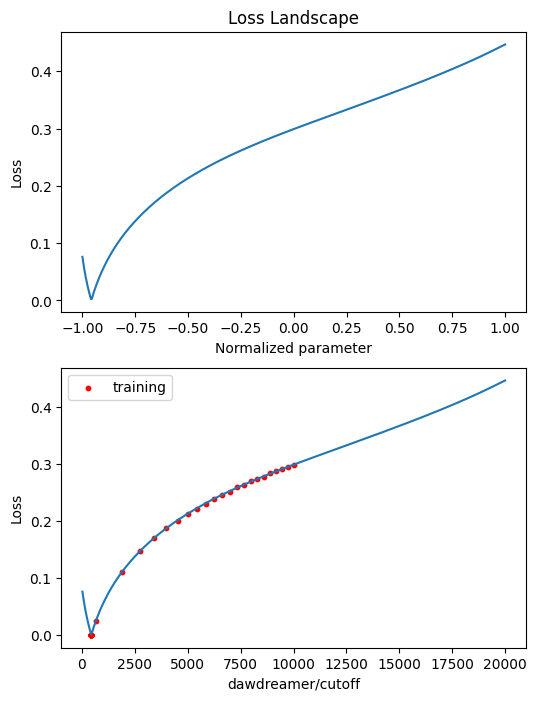

In [11]:
# Pick a single example
x = noises[0:1]
y = hidden_model.apply({'params': hidden_params}, x, T)[0]
x = x[0]

# Pick the first param to be the varying parameter.
# There happens to only be one parameter.
param_name = list(hidden_params.keys())[0]

@jax.jit
def loss_one_sample(params):
    pred, mod_vars = jit_inference_fn({'params': params}, x, T)

    loss = jnp.abs(pred-y).mean()

    return loss, mod_vars['intermediates']

loss_many_samples = jax.vmap(loss_one_sample, in_axes=0, out_axes=0)

loss_landscape_batch = 500

batched_hidden_params = jax.tree_map(lambda x: jnp.tile(x, loss_landscape_batch), hidden_params)
batched_hidden_params = unfreeze(batched_hidden_params)
batched_hidden_params[param_name] = jnp.linspace(-1, 1, loss_landscape_batch)

landscape_losses, mod_vars = loss_many_samples(batched_hidden_params)

plt.figure(figsize=(6,8))

ax1 = plt.subplot(2, 1, 1)
ax1.set_title("Loss Landscape")
ax1.plot(np.array(batched_hidden_params[param_name]), landscape_losses)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Normalized parameter')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(list(mod_vars.values())[0][0], landscape_losses)
ax2.set_ylabel('Loss')
ax2.set_xlabel(list(mod_vars.keys())[0])
ax2.scatter(cutoffs, losses, s=10, color='red', label="training")
ax2.legend()
plt.show()


## Speed benchmarking

JAX is sometimes faster than scipy for large batch sizes of short duration. It's at least good to see they're competitive on simple tests. Whereas JAX can do more complex code generated by Faust, scipy cannot. JAX also supports vmap with different parameters for each item in a batch, while scipy does not.

In [12]:
# Pick our hidden parameters
benchmark_batch_size = 100  #@param {type:"integer"}
Duration_seconds = .1  #@param {type:"number"}

noises_np = -1. + 2.*np.random.random((benchmark_batch_size, 1, int(SAMPLE_RATE*Duration_seconds)))

benchmark_jit = jax.jit(partial(train_model.apply), static_argnums=[2])

benchmark_noise = jnp.array(noises_np)

audio = benchmark_jit({'params': train_params}, benchmark_noise, T)

print('benchmarking JAX:')
%timeit benchmark_jit({'params': train_params}, benchmark_noise, T)

from scipy.signal import lfilter
import scipy.signal
b, a = scipy.signal.butter(1, 440, fs=SAMPLE_RATE)
noises_np = np.array(benchmark_noise)
print('benchmarking scipy:')
lfilter(b, a, noises_np)
%timeit lfilter(b, a, noises_np)

benchmarking JAX:
657 µs ± 8.86 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
benchmarking scipy:
2 ms ± 27.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Caveats

### Gradients (Vanishing and Exploding)

When Faust is converted to JAX, the generated `tick` function is recurrent; one sample is generated at a time. This means that when the gradients are unrolled, one sample is also unrolled at a time, making backpropagation potentially slow. Relying on long recurrent sequences also makes the modules vulnerable to vanishing and exploding gradients.

### Pre-computed tables

Some Faust Library functions pre-compute lookup tables for commonly used functions such as `sine`/`cosine`. In the worst case the lookup could occur with no interpolation between two lookup locations, leading to a gradient of zero. Even with interpolation, it might just be linear interpolation, which is imprecise. If possible, you should use Faust code that is analytically differentiable rather than something involving a pre-computed table.

For example, instead of using `os.osc`, use `goodOsc`:

```faust
import("stdfaust.lib");
goodOsc = phasor : sin
with {
    decimalPart(x) = x-int(x);
    phasor(f) = f/ma.SR : (+ : decimalPart) ~ _;
};
process = goodOsc(440.);
```

To make sure the generated JAX code doesn't have a pre-computed table, you should read the generated `initialize` function and make sure it doesn't have a conspicuous for-loop which writes values into an array.

### Delays

Differentiation might not work well with variable-length delays and table lookups. A variable-length delay is essentially a linear interpolation between two samples (Faust does support fancier [interpolators](https://faustlibraries.grame.fr/libs/interpolators/)). Future research should investigate the robustness of algorithms which involve delay operators, especially time-varying delays.

### Reverb and Convolution

Our generated JAX functions apply reverb and convolutions in the time-domain rather than the frequency-domain. This means the forward pass and backward pass will be slower than if the effects had been calculated in the frequency-domain. The [XLA](https://www.tensorflow.org/xla) compiler might one day be able compile down to an equivalent frequency-domain effect (like a linear-time-invariant filter), but more testing is necessary.

### Loss Function

Using a frequency-domain loss function (or any non-time-domain function) is possible, but it doesn't alleviate the computational speed problems outlined above. In fact, it will almost certainly be slower. However, it may lead to more useful gradients.

# Future Research Directions

## Exporting to C++ and other Backends

We've demonstrated how to convert Faust code into several target languages such as C++ and Python JAX. The generated JAX code can be trained, and optimal parameters can be found. We still need an automated system to bring those parameters back to Faust so that Faust can re-target them to another language such as C++. If the number of parameters is small like the toy problems we've shown, it's not a problem to do this by hand, but for larger DSP systems resembling neural networks, it deserves to be automated.

## Differentiable Digital Signal Processing (DDSP)

[DDSP: Differentiable Digital Signal Processing](https://magenta.tensorflow.org/ddsp) (Engel et al., 2020) advocated for an end-to-end differentiable audio pipeline which many research papers have since adopted. In the diagram below, the Encoder and Decoder are neural networks with learned weights. The green components are latent representations, and yellow components are determinisitic synthesizers and effects. The yellow parts of the diagram can be replaced with JAX code generated with Faust and the expansive [Faust Libraries](https://faustlibraries.grame.fr/).

<center>
<img width="75%" src="https://storage.googleapis.com/ddsp/additive_diagram/ddsp_autoencoder.png"></img>
<p>
<i>DDSP auto-encoder diagram, copyright </i><a href="https://magenta.tensorflow.org/ddsp">Google Magenta</a>
</p>
</center>

DDSP used an additive synthesizer (with a lot of parameters), but let's make a simple subtractive sawtooth synthesizer. We'll have a learnable ADSR envelope modulate a filter cutoff. For simplicity, we'll use a second non-learnable ADSR envelope to modulate the volume.

```faust
import("stdfaust.lib");

eps = .00001;

synth = freq : sawtooth_cycle : _*gain*env2*volume : filter <: _, _
with {

    // UI
    freq = hgroup("voice", vslider("freq", 440., 0., 20000., eps));
    gate = hgroup("voice", button("gate"));
    gain = hgroup("voice", vslider("gain", 0., 0., 1., eps));

    volume = vslider("volume", 0.5, 0., 1., eps);
    
    attack = hgroup("env1", vslider("[0]attack", 0.1, 0., .3, eps));
    decay = hgroup("env1", vslider("[1]decay", 0.1, 0., .3, eps));
    sustain = hgroup("env1", vslider("[2]sustain", .0, 0., 1., eps));
    release = hgroup("env1", vslider("[3]release", 0.2, 0., .3, eps));

    cutoff1 = hgroup("freq mod", vslider("mod1", 440., 20., 20000., eps));
    cutoff2 = hgroup("freq mod", vslider("mod2", 15000., 20., 20000., eps));

    // phasor goes from 0 to 1 with frequency f and loops
    phasor(f) = f/ma.SR : (+ : decimalPart) ~ _
    with {
        decimalPart(x) = x-int(x);
    };

    // remap phasor to [-1, 1]
    sawtooth_cycle(f) = phasor(f)*2-1;

    // an envelope to control the filter cutoff
    env1 = en.adsr(attack, decay, sustain, release, gate);

    // an envelope to control the volume
    env2 = en.adsr(.01, 0.,.9, 0.1, gate);

    // linearly interpolate between the cutoffs
    cutoff = cutoff1 + (cutoff2-cutoff1)*env1;

    filter = fi.lowpass(10, cutoff);
};

process = hgroup("synth", synth);
```

Try this code in the [Faust IDE](https://faustide.grame.fr/?autorun=1&voices=8&name=faust_synth&inline=aW1wb3J0KCJzdGRmYXVzdC5saWIiKTsKCmVwcyA9IC4wMDAwMTsKCnN5bnRoID0gZnJlcSA6IHNhd3Rvb3RoX2N5Y2xlIDogXypnYWluKmVudjIqdm9sdW1lIDogZmlsdGVyIDw6IF8sIF8Kd2l0aCB7CgogICAgLy8gVUkKICAgIGZyZXEgPSBoZ3JvdXAoInZvaWNlIiwgdnNsaWRlcigiZnJlcSIsIDQ0MC4sIDAuLCAyMDAwMC4sIGVwcykpOwogICAgZ2F0ZSA9IGhncm91cCgidm9pY2UiLCBidXR0b24oImdhdGUiKSk7CiAgICBnYWluID0gaGdyb3VwKCJ2b2ljZSIsIHZzbGlkZXIoImdhaW4iLCAwLiwgMC4sIDEuLCBlcHMpKTsKCiAgICB2b2x1bWUgPSB2c2xpZGVyKCJ2b2x1bWUiLCAwLjUsIDAuLCAxLiwgZXBzKTsKICAgIAogICAgYXR0YWNrID0gaGdyb3VwKCJlbnYxIiwgdnNsaWRlcigiWzBdYXR0YWNrIiwgMC4xLCAwLiwgLjMsIGVwcykpOwogICAgZGVjYXkgPSBoZ3JvdXAoImVudjEiLCB2c2xpZGVyKCJbMV1kZWNheSIsIDAuMSwgMC4sIC4zLCBlcHMpKTsKICAgIHN1c3RhaW4gPSBoZ3JvdXAoImVudjEiLCB2c2xpZGVyKCJbMl1zdXN0YWluIiwgLjAsIDAuLCAxLiwgZXBzKSk7CiAgICByZWxlYXNlID0gaGdyb3VwKCJlbnYxIiwgdnNsaWRlcigiWzNdcmVsZWFzZSIsIDAuMiwgMC4sIC4zLCBlcHMpKTsKCiAgICBjdXRvZmYxID0gaGdyb3VwKCJmcmVxIG1vZCIsIHZzbGlkZXIoIm1vZDEiLCA0NDAuLCAyMC4sIDIwMDAwLiwgZXBzKSk7CiAgICBjdXRvZmYyID0gaGdyb3VwKCJmcmVxIG1vZCIsIHZzbGlkZXIoIm1vZDIiLCAxNTAwMC4sIDIwLiwgMjAwMDAuLCBlcHMpKTsKCiAgICAvLyBwaGFzb3IgZ29lcyBmcm9tIDAgdG8gMSB3aXRoIGZyZXF1ZW5jeSBmIGFuZCBsb29wcwogICAgcGhhc29yKGYpID0gZi9tYS5TUiA6ICgrIDogZGVjaW1hbFBhcnQpIH4gXwogICAgd2l0aCB7CiAgICAgICAgZGVjaW1hbFBhcnQoeCkgPSB4LWludCh4KTsKICAgIH07CgogICAgLy8gcmVtYXAgcGhhc29yIHRvIFstMSwgMV0KICAgIHNhd3Rvb3RoX2N5Y2xlKGYpID0gcGhhc29yKGYpKjItMTsKCiAgICAvLyBhbiBlbnZlbG9wZSB0byBjb250cm9sIHRoZSBmaWx0ZXIgY3V0b2ZmCiAgICBlbnYxID0gZW4uYWRzcihhdHRhY2ssIGRlY2F5LCBzdXN0YWluLCByZWxlYXNlLCBnYXRlKTsKCiAgICAvLyBhbiBlbnZlbG9wZSB0byBjb250cm9sIHRoZSB2b2x1bWUKICAgIGVudjIgPSBlbi5hZHNyKC4wMSwgMC4sLjksIDAuMSwgZ2F0ZSk7CgogICAgLy8gbGluZWFybHkgaW50ZXJwb2xhdGUgYmV0d2VlbiB0aGUgY3V0b2ZmcwogICAgY3V0b2ZmID0gY3V0b2ZmMSArIChjdXRvZmYyLWN1dG9mZjEpKmVudjE7CgogICAgZmlsdGVyID0gZmkubG93cGFzcygxMCwgY3V0b2ZmKTsKfTsKCnByb2Nlc3MgPSBoZ3JvdXAoInN5bnRoIiwgc3ludGgpOw%3D%3D)! Press the triangular play button, and then use your `ASDF` keys on the keyboard as a piano. Play with the filter cutoff modulators.

Note that this code involves creating [polyphony-specific](https://faustdoc.grame.fr/manual/midi/) parameters for `freq`, `gain`, and `gate`. When we convert Faust to JAX, UI parameters become JAX params which remain constant during a forward call. Thus, `freq`, `gain`, and `gate` would remain constant, which we don't want. To remedy this, we refactor the code so that these parameters are instead signal inputs.

In [13]:
faust_code = """
import("stdfaust.lib");

eps = .00001;

synth(freq, gain, gate) = freq : sawtooth_cycle : _*gain*env2*volume : filter <: _, _
with {
    volume = vslider("volume", 0.5, 0., 1., eps);
    
    attack = hgroup("env1", vslider("[0]attack", 0.1, 0., .3, eps));
    decay = hgroup("env1", vslider("[1]decay", 0.1, 0., .3, eps));
    sustain = hgroup("env1", vslider("[2]sustain", .0, 0., 1., eps));
    release = hgroup("env1", vslider("[3]release", 0.2, 0., .3, eps));

    cutoff1 = hgroup("freq mod", vslider("mod1", 440., 20., 20000., eps));
    cutoff2 = hgroup("freq mod", vslider("mod2", 15000., 20., 20000., eps));

    // phasor goes from 0 to 1 with frequency f and loops
    phasor(f) = f/ma.SR : (+ : decimalPart) ~ _
    with {
        decimalPart(x) = x-int(x);
    };

    // remap phasor to [-1, 1]
    sawtooth_cycle(f) = phasor(f)*2-1;

    // an envelope to control the filter cutoff
    env1 = en.adsr(attack, decay, sustain, release, gate);

    // an envelope to control the volume
    env2 = en.adsr(.01, 0.,.9, 0.1, gate);

    // linearly interpolate between the cutoffs
    cutoff = cutoff1 + (cutoff2-cutoff1)*env1;

    filter = fi.lowpass(10, cutoff);
};

process = hgroup("synth", synth);
"""

with FaustContext():
    box = boxFromDSP(faust_code)
    model_source_code = boxToSource(box, 'jax', module_name, ['-a', 'jax/minimal.py'])

custom_globals = {}
exec(model_source_code, custom_globals)  # security risk!
# print(model_source_code)

MyDSP = custom_globals[module_name]

model = MyDSP(SAMPLE_RATE)

inputs, outputs = model.getNumInputs(), model.getNumOutputs()
assert inputs == 3  # (freq, gain, gate)
assert outputs == 2  # stereo

print('JAX num inputs: ', inputs, 'num outputs: ', outputs)

JAX num inputs:  3 num outputs:  2


Now we can connect our 3 channels (`freq`,`gain`,`gate`) as a (3,T) shaped tensor to our module.

We'll make `freq` be a constant 440 value, representing Hz. We'll make `gain` and `gate` be 1.0 held for 1 second.

In [14]:
jit_inference_fn = jax.jit(model.apply, static_argnums=[2])

# 2 seconds for render length
T = int(SAMPLE_RATE*2.)

# 1 second
hold_length = int(SAMPLE_RATE*1.)

# Play the synth as 440 Hz.
freq = jnp.full((T,), 440.)
# Hold gain and gate at 1.0 for the hold length
gain = (jnp.arange(0, T) < hold_length).astype(jnp.float32)
gate = gain

x = jnp.stack([freq, gain, gate], axis=0)

assert x.shape[0] == 3  # (freq, gain, gate)

params = model.init({'params': random.PRNGKey(0)}, x, T)['params']
print(params)

{'_synth/env1/attack': Array(-0.33333337, dtype=float32), '_synth/env1/decay': Array(-0.33333337, dtype=float32), '_synth/env1/sustain': Array(-1., dtype=float32), '_synth/env1/release': Array(0.33333325, dtype=float32), '_synth/freq mod/mod1': Array(-0.957958, dtype=float32), '_synth/freq mod/mod2': Array(0.49949944, dtype=float32), '_synth/volume': Array(0., dtype=float32)}


In [15]:
audio = jit_inference_fn({'params': params}, x, T)
audio = np.array(audio)
# This should sound like the Faust IDE.
# A frequency cutoff rises and falls according to an envelope.
show_audio(audio)

In [16]:
# Now that we've jitted it once, subsequent runs should be faster
%timeit jit_inference_fn({'params': params}, x, T)

4 ms ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's compare what we've done to the DDSP diagram again. We replaced the "Harmonic Audio" with a JAX module that takes a 3-channel time-series input. The 3 channels are `freq`, `gain`, and `gate`. We generated these channels by hand in order to hear some audio, but some other Flax module could have generated them.

Note also that DDSP used an additive synthesizer (many sinusoidal oscillators), whereas we've coded a subtractive synthesizer using one sawtooth oscillator. You can still use Faust to code an additive synthesizer just like DDSP. We leave this for future research. We also suggest investigating what would happen if the same module was instantiated in parallel for voices of polyphony with parameter weights shared among the voices. Some other neural network could simultaneously set the frequencies and loudnesses of all the voices. 

Note that the parameters which haven't been lifted into input signals will remain as learnable parameters. For example, the `attack`, `decay`, `sustain`, and `release` parameters on the low-pass filter cutoff are all differentiable and learnable. They showed up in the `FrozenDict` printed above. Beware, it can be difficult to backpropagate through ADSR envelopes.

DDSP introduced many differentiable effects including chorus, flanger, vibrato, and two reverbs. Now that Faust connects to JAX, one can use functions from the [Faust Libraries](https://faustlibraries.grame.fr/) in a DDSP-style pipeline. These include emulations of the [Yamaha DX7 synthesizer](https://faustlibraries.grame.fr/libs/dx7/), [physical modeling](https://faustlibraries.grame.fr/libs/physmodels/), [several reverbs](https://faustlibraries.grame.fr/libs/reverbs/), [high-order ambisonics](https://faustlibraries.grame.fr/libs/hoa/), and more.

## RAVE (**R**ealtime **A**udio **V**ariational auto**E**ncoder)

[RAVE](https://github.com/acids-ircam/RAVE) (Caillon et al., 2020) is a model architecture designed for fast, high-quality, and high sample rate audio generation. We believe it would be possible to re-write RAVE's decoder architecture in Faust. The other parts of the model which are currently in PyTorch would need to be re-written in JAX. Then if the model were trained, we would need to automate the process of re-inserting the parameters into Faust code. Then the Faust code could be exported to C++ with no Max/MSP or libtorch dependency and run with extremely low latency (8 samples) on [microcontrollers](https://faustdoc.grame.fr/tutorials/esp32/). [Several researchers](https://team.inria.fr/emeraude/) are already testing Faust with FPGAs (Field Programmable Gate Arrays). We hope RAVE or similar models will eventually be run on an FPGA.

## State-Space Models (SSM)

Besides writing a large portion of the Faust Libraries, [Julius Smith](https://ccrma.stanford.edu/~jos/) has written [Faust code for a digital State-Space Model](https://ccrma.stanford.edu/~jos/aspf/Appendix_A_State_Space_Models.html). Once exported to JAX, this would be a nicely parameterized system for audio effect modeling. Another starter code for neural networks written in Faust is [here](https://github.com/grame-cncm/faust/blob/master-dev/examples/filtering/DNN.dsp).

## Sound files

Faust can use sound files such as `.wav` files. See the [syntax manual](https://faustdoc.grame.fr/manual/syntax/#soundfile-primitive).

Thus we can try this Faust code:
```faust
reader = _~+(1);
process = 0,reader:soundfile("mySound[url:{'foo.wav'}]",2);
```

and still convert it to JAX. In fact, we can specify the sound file as a learnable parameter by prefixing it with `param:`.

In [17]:
faust_code = """
import("stdfaust.lib");
reader = _~+(1);
process = 0,reader:soundfile("param:mySound[url:{'foo.wav'}]",2) : !, !, si.bus(2);
"""

with FaustContext():

    box = boxFromDSP(faust_code)

    print(f'Inputs: {box.inputs}, Outputs: {box.outputs}')

    module_name = "MyDSP"
    jax_code = boxToSource(box, 'jax', module_name, ['-a', 'jax/minimal.py'])
    # print(jax_code)

    custom_globals = {}

    exec(jax_code, custom_globals)

    MyDSP = custom_globals[module_name]
    model = MyDSP(SAMPLE_RATE)

    # The JAX code will involve calling
    #   self.add_soundfile(state, x, "param:mySound", "{'foo.wav'}", "fSoundfile0")
    # which will subsequently call
    #   self.load_soundfile(self, "foo.wav")
    # Then a learnable jnp.array will be initialized from the audio file "foo.wav".
    # This learnable array is in the params:
    
    params = model.init({'params': random.PRNGKey(0)}, noises[0], T)['params']
    print('params:', params)


Inputs: 0, Outputs: 2
params: {'_dawdreamer/mySound': Array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}


<string>:112: UserWarning: PySoundFile failed. Trying audioread instead.
/home/braun/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


This opens opportunities for [Differentiable Wavetable Synthesis](https://arxiv.org/abs/2111.10003v4) (Shan et al., 2021) using Faust and JAX. Remember that the Flax module you create with Faust can be combined with other Flax modules unrelated to Faust.

## The Faust box API

We've been writing Faust code "manually" and then converting it to JAX. Instead it's possible to use DawDreamer's Python bindings to the Faust box API to create JAX code. For a list of box operators, see the [DawDreamer documentation](https://dirt.design/DawDreamer/_generate/dawdreamer.faust.box.html). For more examples of the box API, check out the box API tutorial: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/DBraun/DawDreamer/blob/main/examples/Box_API/Faust_Box_API.ipynb)

In [18]:
with FaustContext():
    
    # Create a box representing an input signal (1 input and 1 output).
    box1 = boxWire()

    # since box1 has one output, we can perform simple built-in arithmetic operators on it
    box2 = box1 + 0.5
    # alternatively, we could have done
    # box2 = boxAdd(box1, boxReal(0.5))

    # box2 still has 1 input and 1 output.

    box3 = box2 * 1.5
    # box3 still has 1 input and 1 output.

    box4 = boxAtan2(box2, box3)
    # box4 has 2 inputs (because box2 and box3 both have 1 input) and 1 output.

    box5 = boxFromDSP("process = fi.lowpass(2, 10000);")
    # box5 has 1 input and 1 output.

    # box4's outputs (1) == box5's inputs (1), so we can sequence them
    box6 = boxSeq(box4, box5)

    jax_code = boxToSource(box6, 'jax', module_name)
    # print(jax_code)

We encourage you to find interesting ways of using the box API in combination with JAX. One idea is making a [modular synthesizer](https://github.com/DBraun/DawDreamer/blob/main/tests/box_instruments.py). Other possibilities are [Cartesian Genetic Programming](https://link.springer.com/chapter/10.1007/978-3-642-17310-3_2), [program synthesis/induction](https://arxiv.org/abs/2006.08381), [other](https://github.com/google/evojax) [evolutionary algorithms](https://arxiv.org/abs/2206.08896), and [graph neural networks](https://github.com/google-deepmind/jraph).

## Quality-Diversity algorithms

[QDax](https://github.com/adaptive-intelligent-robotics/QDax/) is a library of JAX code for Quality-Diversity algorithms, which are a class of neuro-evolution algorithms. The motivation behind QD is that for some problems, multiple and very different solutions can exist. Therefore, we want algorithms that can adequately explore the parameter space without giving too much preference to one region. Luckily, the Faust to JAX pipeline works with QDax! It's particularly useful when the loss landscape is very deceptive or when backpropagation is still too slow.

Check out the Faust to QDax Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/DBraun/DawDreamer/blob/main/examples/Faust_to_QDax/Faust_to_QDax.ipynb)